In [8]:
from rdkit.Chem import MolFromSmiles
from rdkit.Chem.Descriptors import ExactMolWt
from mordred import Calculator, descriptors
import matplotlib.pyplot as plt

I wanted to have to calculate only descriptors of my choice to avoid any unnessary computational overload. The way it can be done is [explained in this GitHub issue](https://github.com/mordred-descriptor/mordred/issues/73)

In [32]:
desc_needed = {'SIC0': 'Basak SIC0',
               'IC0': 'Basak IC0',
               'CIC0': 'Basak CIC0',
               'nRot': 'Number of rotatable bonds',
               'nN': 'Number of Nitrogen atoms',
               'nH': 'Number of Hydrogen atoms',
               'nC': 'Number of Carbon atoms',
               'nS': 'Number of Sulphur atoms',
               'nO': 'Number of Oxygen atoms',
               'nHBDon': 'Number of H-Bond donors',
               'nHBAcc': 'Number of H-Bond acceptors',
               'GeomDiameter': 'Geometrical Diameter',
               'GeomRadius': 'Geometrical Radius',
               'TopoPSA': 'Topological PSA',
               'SLogP': 'SLogP',
               'RASA': 'RASA',
               'TASA': 'TASA',
               'TPSA': 'TPSA',
               'RNCS': 'RNCS',
               'RPCS': 'RPCS',
               'RPSA': 'RPSA'}

calc = Calculator(descriptors, ignore_3D=False)
calc.descriptors = [d for d in calc.descriptors if str(d) in desc_needed.keys()]

Now calculate them

In [9]:
molecules_list = []
weights_list = []
# open the output .txt
count = 0
with open('../main/glucose/glucose_degradation_output.txt') as glu_out:
    contents = glu_out.readlines()
    for line in contents:
        # get rid of \n at the end of the line
        line = line.rstrip('\n')
        # break line into components separated by a tabspace
        comps = line.split("\t")
        gen_num = int(comps[0][1])
        mol = MolFromSmiles(comps[1])
        weight = ExactMolWt(mol)
        
        molecules_list.append(mol)
        weights_list.append(weight)
        # testing with the first 100 molecules
        if count > 100:
            break
        count += 1

In [4]:
result = calc.pandas(molecules_list)

100%|██████████| 102/102 [00:00<00:00, 672.69it/s]


In [5]:
result.head()

,nH,nC,nN,nO,nS,RNCS,RPCS,TASA,TPSA,RASA,...,GeomDiameter,GeomRadius,nHBAcc,nHBDon,IC0,SIC0,CIC0,nRot,SLogP,TopoPSA
0,4,2,0,2,0,missing 3D coordinate (RNCS/RNCG/AtomicCharge/...,missing 3D coordinate (RNCS/RNCG/AtomicCharge/...,missing 3D coordinate (RNCS/RNCG/AtomicCharge/...,missing 3D coordinate (RNCS/RNCG/AtomicCharge/...,missing 3D coordinate (RNCS/RNCG/AtomicCharge/...,...,missing 3D coordinate (GeomDiameter/mordred._g...,missing 3D coordinate (GeomDiameter/mordred._g...,2,1,1.500000,0.500000,1.500000,1,-0.8224,37.30
1,8,4,0,4,0,missing 3D coordinate (RNCS/RNCG/AtomicCharge/...,missing 3D coordinate (RNCS/RNCG/AtomicCharge/...,missing 3D coordinate (RNCS/RNCG/AtomicCharge/...,missing 3D coordinate (RNCS/RNCG/AtomicCharge/...,missing 3D coordinate (RNCS/RNCG/AtomicCharge/...,...,missing 3D coordinate (GeomDiameter/mordred._g...,missing 3D coordinate (GeomDiameter/mordred._g...,4,3,1.500000,0.375000,2.500000,3,-2.1006,77.76
2,12,6,0,6,0,missing 3D coordinate (RNCS/RNCG/AtomicCharge/...,missing 3D coordinate (RNCS/RNCG/AtomicCharge/...,missing 3D coordinate (RNCS/RNCG/AtomicCharge/...,missing 3D coordinate (RNCS/RNCG/AtomicCharge/...,missing 3D coordinate (RNCS/RNCG/AtomicCharge/...,...,missing 3D coordinate (GeomDiameter/mordred._g...,missing 3D coordinate (GeomDiameter/mordred._g...,6,5,1.500000,0.327156,3.084963,5,-3.3772,118.22
3,12,6,0,7,0,missing 3D coordinate (RNCS/RNCG/AtomicCharge/...,missing 3D coordinate (RNCS/RNCG/AtomicCharge/...,missing 3D coordinate (RNCS/RNCG/AtomicCharge/...,missing 3D coordinate (RNCS/RNCG/AtomicCharge/...,missing 3D coordinate (RNCS/RNCG/AtomicCharge/...,...,missing 3D coordinate (GeomDiameter/mordred._g...,missing 3D coordinate (GeomDiameter/mordred._g...,6,6,1.516624,0.326587,3.127232,5,-3.4931,138.45
4,14,6,0,6,0,missing 3D coordinate (RNCS/RNCG/AtomicCharge/...,missing 3D coordinate (RNCS/RNCG/AtomicCharge/...,missing 3D coordinate (RNCS/RNCG/AtomicCharge/...,missing 3D coordinate (RNCS/RNCG/AtomicCharge/...,missing 3D coordinate (RNCS/RNCG/AtomicCharge/...,...,missing 3D coordinate (GeomDiameter/mordred._g...,missing 3D coordinate (GeomDiameter/mordred._g...,6,6,1.457266,0.310028,3.243174,5,-3.5854,121.38


In [6]:
result['RASA']

0      missing 3D coordinate (RNCS/RNCG/AtomicCharge/...
1      missing 3D coordinate (RNCS/RNCG/AtomicCharge/...
2      missing 3D coordinate (RNCS/RNCG/AtomicCharge/...
3      missing 3D coordinate (RNCS/RNCG/AtomicCharge/...
4      missing 3D coordinate (RNCS/RNCG/AtomicCharge/...
                             ...                        
97     missing 3D coordinate (RNCS/RNCG/AtomicCharge/...
98     missing 3D coordinate (RNCS/RNCG/AtomicCharge/...
99     missing 3D coordinate (RNCS/RNCG/AtomicCharge/...
100    missing 3D coordinate (RNCS/RNCG/AtomicCharge/...
101    missing 3D coordinate (RNCS/RNCG/AtomicCharge/...
Name: RASA, Length: 102, dtype: object

In [8]:
print(len(result.columns))

20


The Dataframe can be easily exported into a CSV as well

In [32]:
print(result['RASA'].iloc[1])

missing 3D coordinate (RNCS/RNCG/AtomicCharge/Propc/AtomicSurfaceArea)


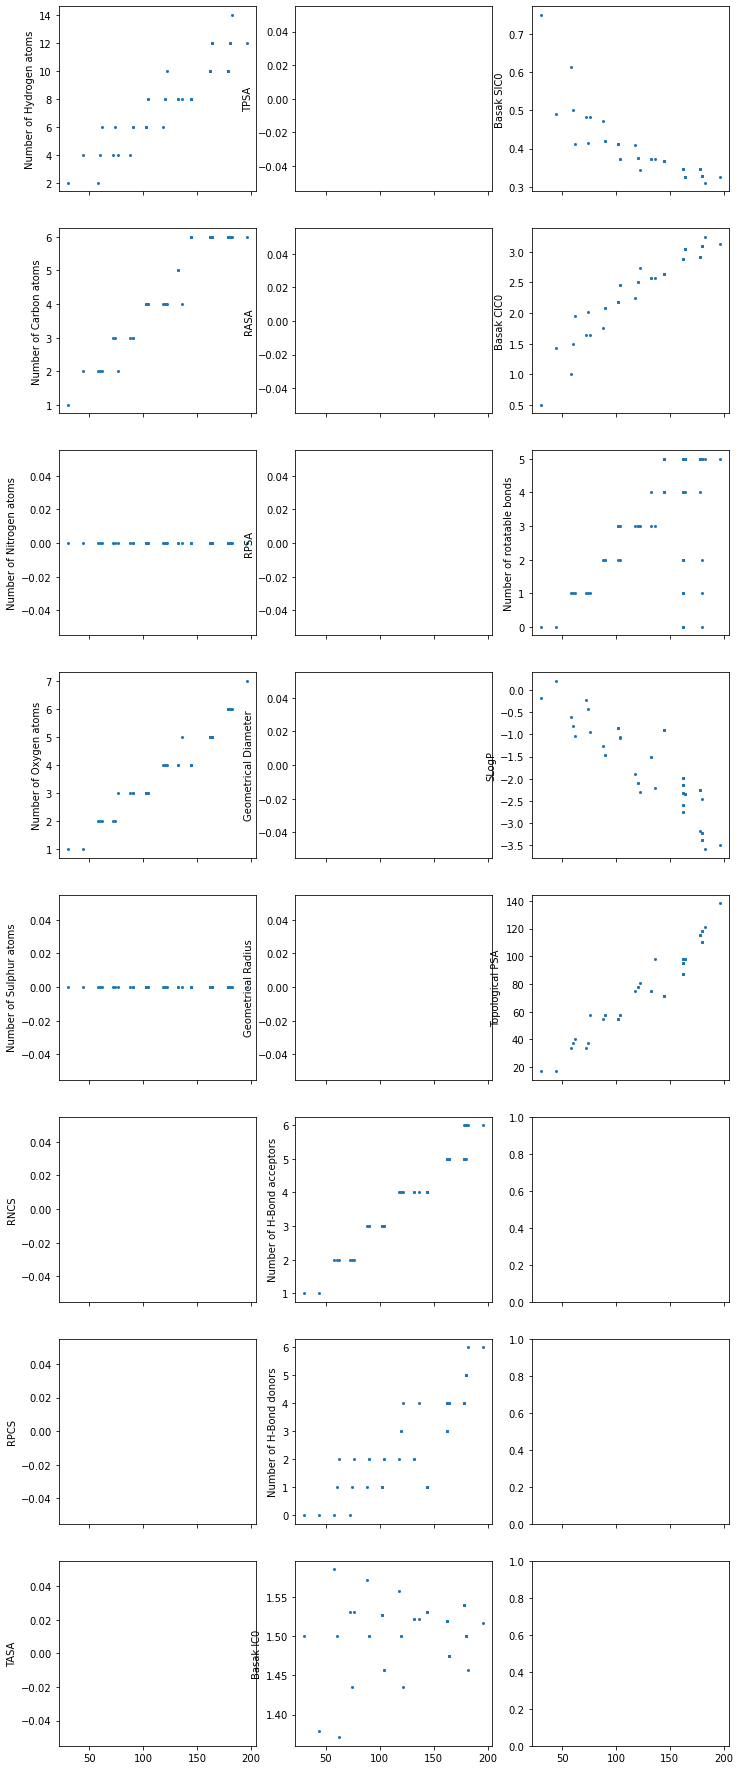

In [34]:
fig = plt.figure(figsize=(12,32))
axes = fig.subplots(nrows=8, ncols=3, sharex=True)
for col_id, col in enumerate(result.columns):
    axes[col_id%8, col_id//8].plot(weights_list, result[col], linestyle='', marker='o', markersize=2)
    axes[col_id%8, col_id//8].set_ylabel(desc_needed[col])